# Gender image categorization using neural networks


## Author: Ángel López Manríquez


### Objectives: 
Given an image with only one face, determine its gender.
### What is done in the Notebook: 
Preprocessing the data and the use of several classifiers algorithms.

In [5]:
# Fundamental datascience libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2  # computer vision 2 library

# standard python modules
import random
import os
import urllib.request  # fetch images from an url


from IPython.display import display, HTML, Markdown  # exclusive for jupyter notebook
from tqdm import tqdm  # Very cool progress bar :D
from typing import List, Tuple  # Explicit declaration type for collections, python 3.7+
from collections import Counter  # counts how many instance we have

from sklearn import preprocessing

In [6]:
plt.style.use('seaborn')  # improve plot style

def display_markdown(*args, **kargs):
    '''The main use of is beeing able to display something in a notebook from another function.'''
    display(Markdown(*args, **kargs))

## Data visualization
By loading the dataset, we realize the we only care about the image url and the gender label, everything else is useless. 

In [11]:
fname = 'a943287.csv'  # dataset name
df = pd.read_csv(fname)
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,please_select_the_gender_of_the_person_in_the_picture,please_select_the_gender_of_the_person_in_the_picture:confidence,image_url,please_select_the_gender_of_the_person_in_the_picture_gold,user_id
0,1023132475,False,finalized,1,8/19/2016 17:00:25,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/40...,NaN,40
1,1023132476,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/42...,NaN,42
2,1023132477,False,finalized,1,8/19/2016 17:01:43,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/44...,NaN,44
3,1023132478,False,finalized,1,8/19/2016 17:01:04,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/47...,NaN,47
4,1023132479,False,finalized,1,8/19/2016 17:00:48,male,1.0,https://d1qb2nb5cznatu.cloudfront.net/users/50...,NaN,50


Let's count the number of instances per class.



In [12]:
gender_labels = df.please_select_the_gender_of_the_person_in_the_picture.values
counter = Counter(gender_labels)
display(counter)  # display unique label values

Counter({'male': 47595, 'female': 7367, 'unsure': 9122})

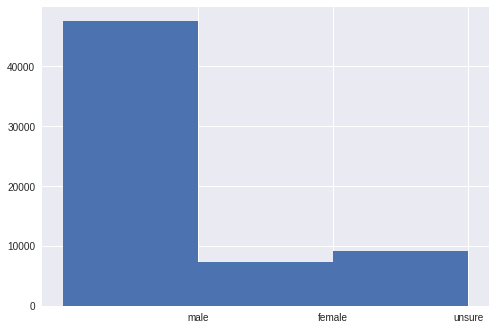

In [10]:
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

We realize there are some images which does not contain faces, tagged as 'unsure', we will drop them.
Also, we have more samples for man than woman, Our approach will be training the model with the same amount of man and woman faces.

In [16]:
display('''Lenght with "unsure" labels''', df.shape)
df = df[df.please_select_the_gender_of_the_person_in_the_picture != 'unsure']  # drop irrelevant rows
display('''Lenght without "unsure" labels''', df.shape)

'Lenght with "unsure" labels'

(54962, 10)

'Lenght without "unsure" labels'

(54962, 10)

In [78]:
X = df['image_url'].values  # list of urls where will be able to download the image
y = np.array(df['please_select_the_gender_of_the_person_in_the_picture'].values)

X[:5], y[:5]

(array(['https://d1qb2nb5cznatu.cloudfront.net/users/40-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/42-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/44-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/47-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/50-large'],
       dtype=object),
 array(['male', 'male', 'male', 'male', 'male'], dtype=object))

In [79]:

le = preprocessing.LabelEncoder()
y = le.fit_transform(y)
X[:5], y[:5]

(array(['https://d1qb2nb5cznatu.cloudfront.net/users/40-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/42-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/44-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/47-large',
        'https://d1qb2nb5cznatu.cloudfront.net/users/50-large'],
       dtype=object), array([1, 1, 1, 1, 1]))

In [80]:
le.inverse_transform(y)

array(['male', 'male', 'male', ..., 'male', 'male', 'male'], dtype=object)

In [81]:

def make_dir(folder: str) -> None:
    if not os.path.exists(folder):
        os.mkdir(folder)

def save_img(img_url: str, filepath: str) -> None:
    try:
        with urllib.request.urlopen(img_url) as url:
            s = url.read()
    except urllib.error.HTTPError:
        print('Image not found or no internet connection')
        return  # image not found
    with open(filepath, 'wb') as f:
        f.write(s)


In [82]:
def download_males_females(urls: List[str], labels: List[int], n: int, seed=None) -> None:
    counter = Counter(labels)
    n = min(min(counter[0], counter[1]), n)
    indexes = list(range(len(labels)))
    male_indexes = []
    female_indexes = []
    random.shuffle(indexes)
    i = 0
    while len(male_indexes) < n and len(female_indexes) < n:  # TODO: use counters
        male_indexes.append(i) if labels[i] == MALE_LABEL else female_indexes.append(i)
        i += 1
    for gender_indexes, gender_label in ((male_indexes, MALE_LABEL), (female_indexes, FEMALE_LABEL)):
        while len(gender_indexes) < n:  # while executed once
            if labels[i] == gender_label: 
                gender_indexes.append(i)
            i += 1
    for i, j in zip(male_indexes, female_indexes):
        print(f'{i+1}/{len(male_indexes)}')
        save_img(urls[i], os.path.join('img', 'male', f'{i}.jpg'))
        save_img(urls[j], os.path.join('img', 'female', f'{j}.jpg'))
 




In [83]:
MALE_PATH = os.path.join('img', 'male')
FEMALE_PATH = os.path.join('img', 'female')

def set_local_dataset(url_list: List[str], labels: List[int], n: int) -> bool:
    exists_img = os.path.exists('img')
    if exists_img  \
            and len(os.listdir(os.path.join('img', 'male'))) == n  \
            and len(os.listdir(os.path.join('img', 'female'))) == n:
        return
    make_dir('img')
    make_dir(os.path.join('img', 'male'))
    make_dir(os.path.join('img', 'female'))

    download_males_females(url_list, labels, n)
        
MALE_LABEL = 1
FEMALE_LABEL = 0
set_local_dataset(X, y, 25)

1/25
2/25
3/25
4/25
5/25
Image not found or no internet connection
6/25
7/25
8/25
9/25
10/25
11/25
12/25
13/25
14/25
15/25
17/25
18/25
19/25
20/25
21/25
22/25
23/25
24/25
25/25
26/25


In [84]:


def gender_imgs(gender: str) -> List[np.array]:
    subdirpath = os.path.join('img', gender)
    return [cv2.imread(os.path.join(subdirpath, bname)) 
            for bname in os.listdir(subdirpath)]

def get_dataset():
    males = gender_imgs('male')
    females = gender_imgs('female')
    X = females
    y = [0 for _ in females]
    X += males
    y += [1 for _ in males]
    return np.array(X), np.array(y)


X, y = get_dataset()
print(X.shape, y.shape)


(49, 300, 300, 3) (49,)


In [85]:
for i, x in enumerate(X):
    if x is None:
        print(i)

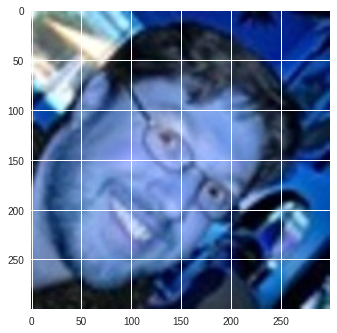

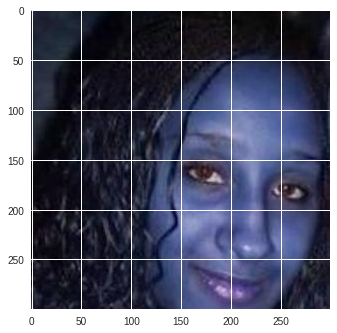

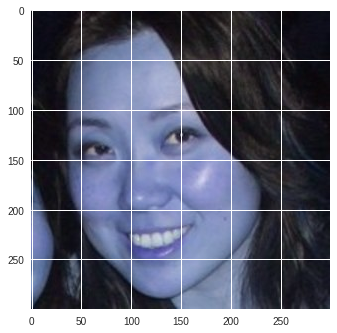

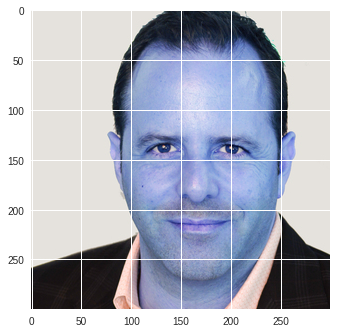

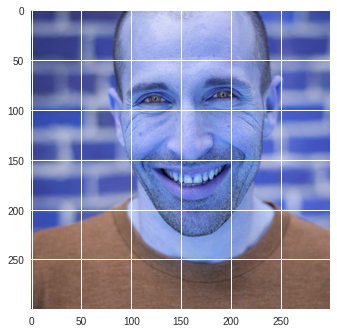

In [86]:

for img_arr in random.sample(list(X), 5):
    plt.imshow(img_arr)
    plt.show()



In [87]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


print(X.shape, y.shape)  # index, i, j, rgb
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

#  normalize the data between 0-1
X_train = X_train / 255  
X_test = X_test / 255



(49, 300, 300, 3) (49,)


In [89]:
X_train[0].shape

(300, 300, 3)

In [90]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential([
    Flatten(input_shape=X_train[0].shape),
    Dense(64, activation='relu'),
    Dense(2, activation='softmax')])

model.compile(loss='categorical_crossentropy', # loss function used for classes that are greater than 2)
              optimizer='adam',
              metrics=['accuracy'])



In [91]:

model.fit(X_train, y_train_one_hot, epochs=20)


Epoch 1/20
39/39 [==============================] - 0s 13ms/step - loss: 1.0582 - accuracy: 0.5128
Epoch 2/20
39/39 [==============================] - 0s 10ms/step - loss: 145.6061 - accuracy: 0.4872
Epoch 3/20
39/39 [==============================] - 0s 12ms/step - loss: 104.0395 - accuracy: 0.5641
Epoch 4/20
39/39 [==============================] - 0s 9ms/step - loss: 21.8955 - accuracy: 0.7436
Epoch 5/20
39/39 [==============================] - 0s 11ms/step - loss: 73.5805 - accuracy: 0.4615
Epoch 6/20
39/39 [==============================] - 0s 11ms/step - loss: 22.6499 - accuracy: 0.6410
Epoch 7/20
39/39 [==============================] - 0s 11ms/step - loss: 27.0247 - accuracy: 0.6154
Epoch 8/20
39/39 [==============================] - 0s 11ms/step - loss: 13.2632 - accuracy: 0.6923
Epoch 9/20
39/39 [==============================] - 0s 11ms/step - loss: 16.7296 - accuracy: 0.6923
Epoch 10/20
39/39 [==============================] - 0s 11ms/step - loss: 7.2659 - accuracy: 0.7949

In [92]:
test_loss, test_acc = model.evaluate(X_test,  y_test_one_hot, verbose=2)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.699999988079071
